# Chapter 7 Ensemble Learning and Random Forests


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib as mpl

# Voting classifiers


In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(
    1, 10001).reshape(-1, 1)

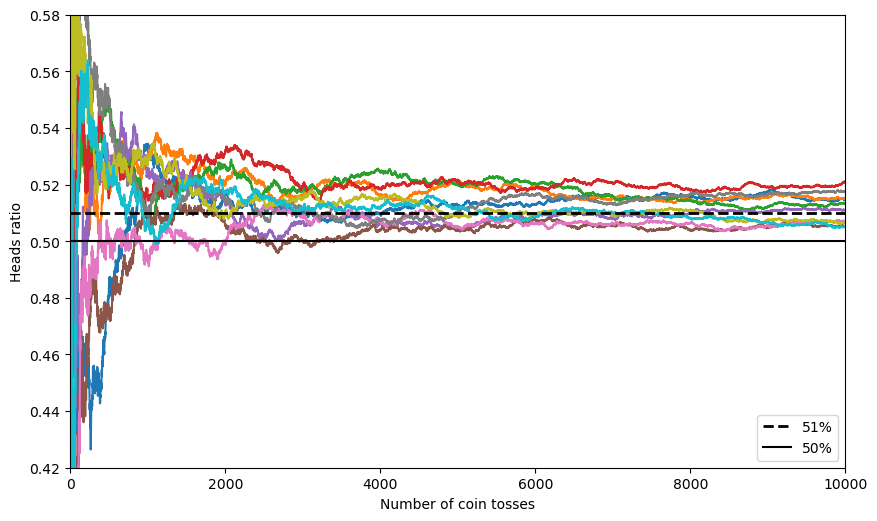

In [5]:
_, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.plot(cumulative_heads_ratio)
ax.plot([0, 10000], [0.51, 0.51], "k--", lw=2, label="51%")
ax.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
ax.set(xlabel="Number of coin tosses",
       ylabel="Heads ratio",
       xlim=[0, 10000],
       ylim=[0.42, 0.58])
ax.legend(loc="lower right")

plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [7]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='hard')


In [10]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [12]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting:


In [13]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf),
                                          ('svc', svm_clf)],
                              voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [14]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging ensembles


In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [16]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt",
                                                   max_leaf_nodes=16),
                            n_estimators=500,
                            bootstrap=True,
                            random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [17]:
print(accuracy_score(y_test, y_pred))

0.912


In [18]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


#### The decision boundary plot code

In [19]:
from matplotlib.colors import ListedColormap

In [20]:
def make_mesh(lims, h):
    x = np.linspace(lims[0], lims[1], h)
    y = np.linspace(lims[2], lims[3], h)
    xx, yy = np.meshgrid(x, y)
    return xx, yy

In [21]:
def plot_decision_boundary(clf,
                           X,
                           y,
                           ax,
                           lims=[-1.5, 2.45, -1, 1.5],
                           contour=True):

    x1, x2 = make_mesh(lims, 100) # invoke the make_mesh func
    X_new = np.c_[x1.flatten(), x2.flatten()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    ax.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=0.2)
    ax.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=0.2)
    ax.set(xlabel=r"$x_1$", ylabel=r"$x_2$")

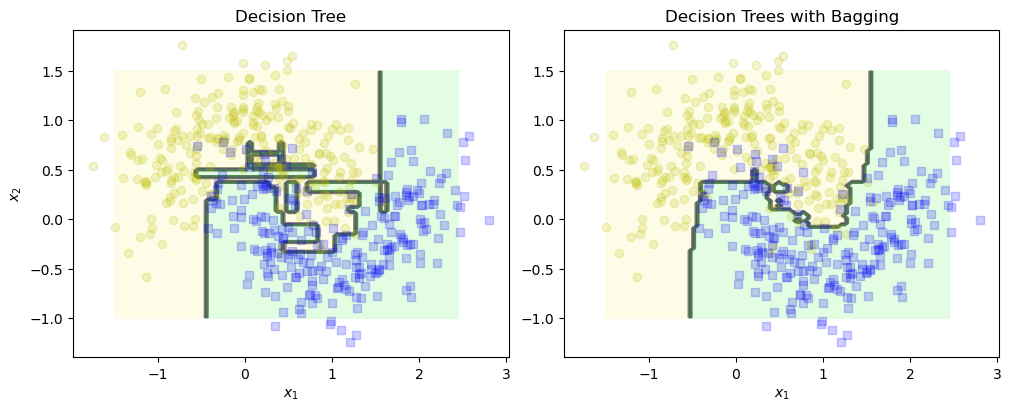

In [22]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, constrained_layout=True)

plot_decision_boundary(tree_clf, X, y, ax=axes[0])
axes[0].set(title="Decision Tree")
plot_decision_boundary(bag_clf, X, y, ax=axes[1])
axes[1].set(title="Decision Trees with Bagging", ylabel="")

plt.show()

## Random Forests


In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [24]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [27]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

In [28]:
from sklearn.datasets import load_iris

iris = load_iris()

In [29]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [30]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

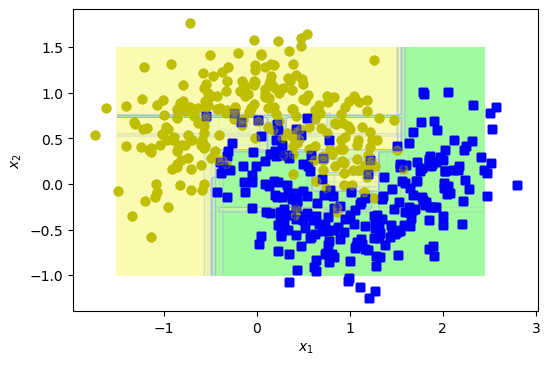

In [31]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf,
                           X,
                           y,
                           ax,
                           lims=[-1.5, 2.45, -1, 1.5],
                           contour=False)

plt.show()

## Out-of-Bag evaluation


In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            bootstrap=True,
                            oob_score=True,
                            random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [33]:
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [34]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

## Feature importance


In [35]:
# from sklearn.datasets import fetch_openml

# X, y = fetch_openml('mnist_784',
#                     version=1,
#                     as_frame=True,
#                     return_X_y=True,
#                     data_home='data')
# y = y.astype(np.int8)
# X.to_feather('data/mnist_784_X.feather')
# y.to_frame().to_feather('data/mnist_784_y.feather')
X = pd.read_feather('../data/mnist_784_X.feather')
y = pd.read_feather('../data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_11572/867223868.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X, y)


RandomForestClassifier(random_state=42)

In [37]:
def plot_digit(data, ax):
    image = data.reshape(28, 28)
    img = ax.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    ax.axis("off")
    return img

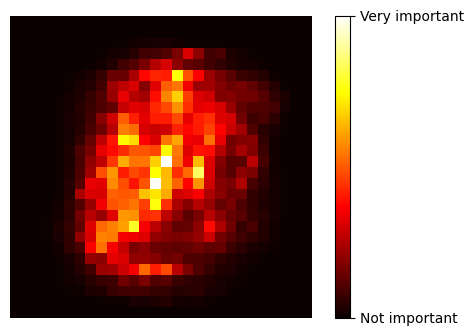

In [38]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

img = plot_digit(rnd_clf.feature_importances_, ax)

cbar = _.colorbar(img,
                    ticks=[
                        rnd_clf.feature_importances_.min(),
                        rnd_clf.feature_importances_.max()
                    ],
                    ax=ax)

cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# AdaBoost


In [39]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor

In [41]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5,
                             random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

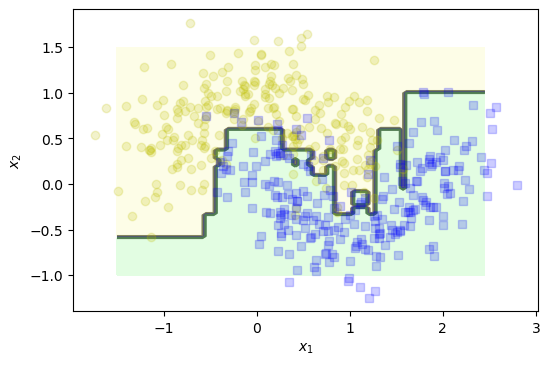

In [42]:
_, ax = plt.subplots(figsize=(6, 4), dpi=100)

plot_decision_boundary(ada_clf, X, y, ax=ax)

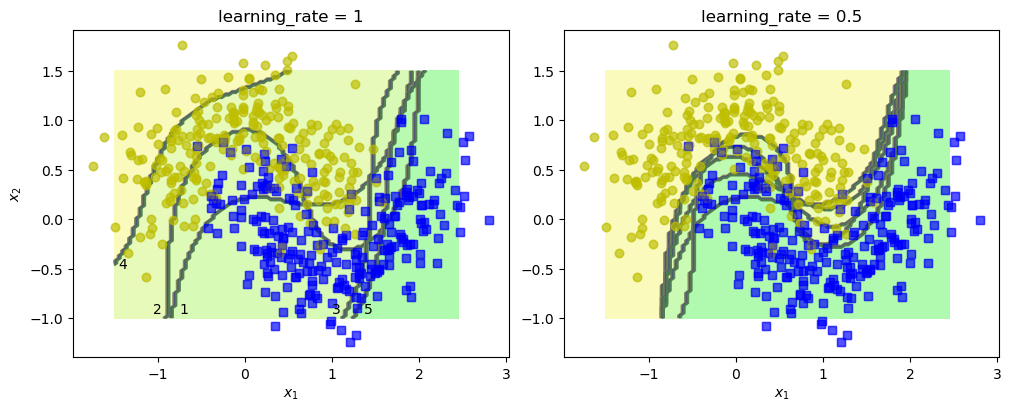

In [43]:
m = len(X_train)

_, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, constrained_layout=True)

for learning_rate, ax in zip((1, 0.5), axes.flatten()):
    sample_weights = np.ones(m) / m

    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[
            y_pred != y_train].sum() / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X, y, ax)
        ax.set(title=f"learning_rate = {learning_rate}")
    if learning_rate == 1:
        ax.text(-0.75, -0.95, "1", fontsize='medium')
        ax.text(-1.05, -0.95, "2", fontsize='medium')
        ax.text(1.0, -0.95, "3", fontsize='medium')
        ax.text(-1.45, -0.5, "4", fontsize='medium')
        ax.text(1.36, -0.95, "5", fontsize='medium')
    else:
        ax.set(ylabel="")

plt.show()

# Gradient Boosting


In [44]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [45]:
from sklearn.tree import DecisionTreeRegressor

In [46]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [47]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [48]:
def plot_predictions(regressors,
                     X,
                     y,
                     ax,
                     lims,
                     ensemble=False,
                     residual=False,
                     label=None):
    x1 = np.linspace(lims[0], lims[1], 500)
    y_pred = sum(
        regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)

    style = "r-" if ensemble else "g-"
    data_style = "k+" if residual else "b."
    data_label = "Residuals" if residual else "Training Set"

    ax.plot(X[:, 0], y, data_style, label=data_label)
    ax.plot(x1, y_pred, style, lw=2, label=label)
    ax.set(xlim=[lims[0], lims[1]], ylim=[lims[2], lims[3]])
    ax.legend(loc="upper center", fontsize="large")


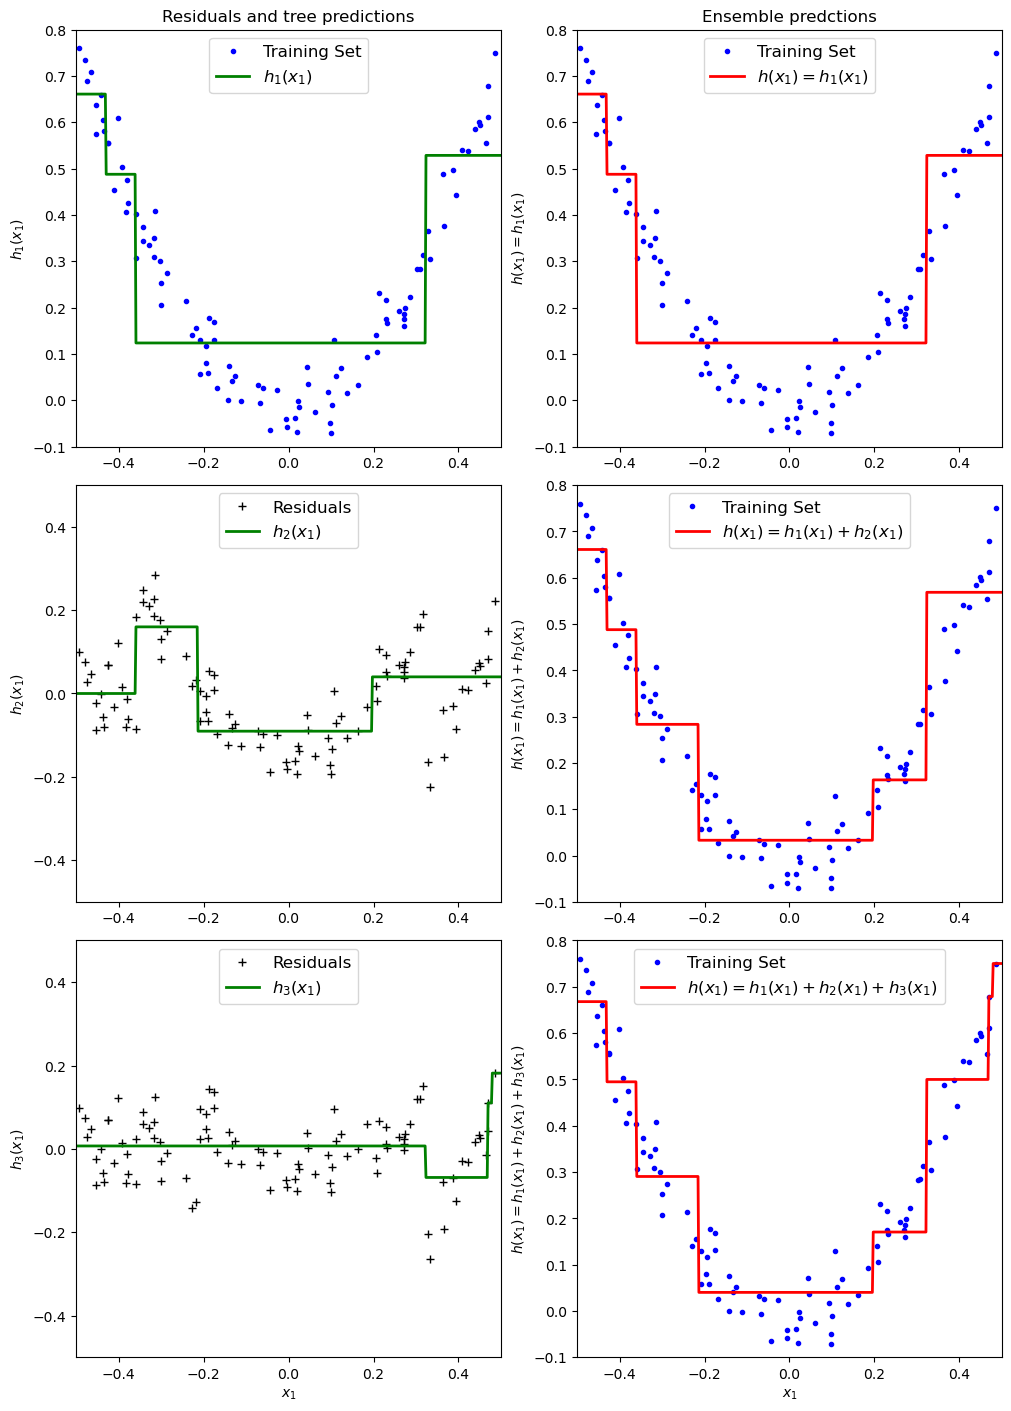

In [49]:
_, axes = plt.subplots(3,2,figsize=(10,14),dpi=100,constrained_layout=True)

data_ys = [y, y, y2, y, y3, y]
regs = [[tree_reg1], [tree_reg1], [tree_reg2], [tree_reg1, tree_reg2],
        [tree_reg3], [tree_reg1, tree_reg2, tree_reg3]]
lims = [[-0.5, 0.5, -0.1, 0.8], [-0.5, 0.5, -0.1, 0.8], [-0.5, 0.5, -0.5, 0.5],
        [-0.5, 0.5, -0.1, 0.8], [-0.5, 0.5, -0.5, 0.5], [-0.5, 0.5, -0.1, 0.8]]
labels = [
    "$h_1(x_1)$", "$h(x_1) = h_1(x_1)$", "$h_2(x_1)$",
    "$h(x_1) = h_1(x_1) + h_2(x_1)$", "$h_3(x_1)$",
    "$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$"
]
ylabels = [
    "$y$", "$y$", "$y - h_1(x_1)$", "$y$", "$y - h_1(x_1) - h_2(x_1)$", "y"
]
ensembles = [False, True, False, True, False, True]
residuals = [False, False, True, False, True, False]

### Notice here:

for reg,data_y,lim,ylabel,label,ensembel,residual,ax in zip(regs,data_ys,lims,ylabels,labels,ensembles,residuals,axes.flatten()):
    plot_predictions(reg,X,data_y,ax,lims=lim,ensemble=ensembel,residual=residual,label=label)
    ax.set(ylabel=label)

axes[0,0].set(title="Residuals and tree predictions")
axes[0,1].set(title="Ensemble predctions")
axes[2,0].set(xlabel="$x_1$")
axes[2,1].set(xlabel="$x_1$")
plt.show()

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0,random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [52]:
gbrt_slow = GradientBoostingRegressor(
    max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42
)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

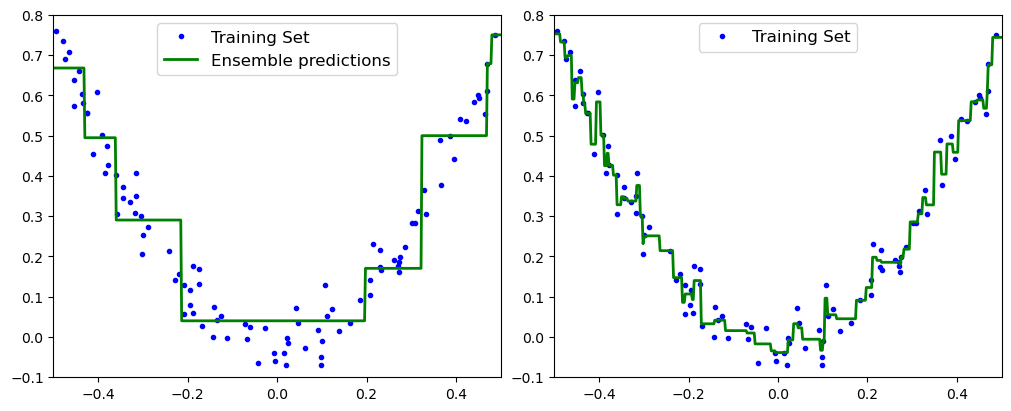

In [53]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, constrained_layout=True)

plot_predictions(
    [gbrt], X, y, ax=axes[0], lims=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions"
)

ax.set(
    xlabel="$x_1$",
    ylabel="$y$",
    title=f"Learning rate = {gbrt.learning_rate}, n_estimators = {gbrt.n_estimators}",
)


plot_predictions([gbrt_slow], X, y, lims=[-0.5, 0.5, -0.1, 0.8], ax=axes[1])
ax.set(
    xlabel="$x_1$",
    title=f"Learning rate = {gbrt_slow.learning_rate}, n_estimators = {gbrt_slow.n_estimators}",
)


plt.show()

### Gradient Boosting with Early stopping


In [54]:
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=120,
                                 random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)

In [56]:
errors = [
    mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)
]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,
                                      n_estimators=bst_n_estimators,
                                      random_state=42)
gbrt_best.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [57]:
min_error = np.min(errors)
min_error

0.002712853325235463

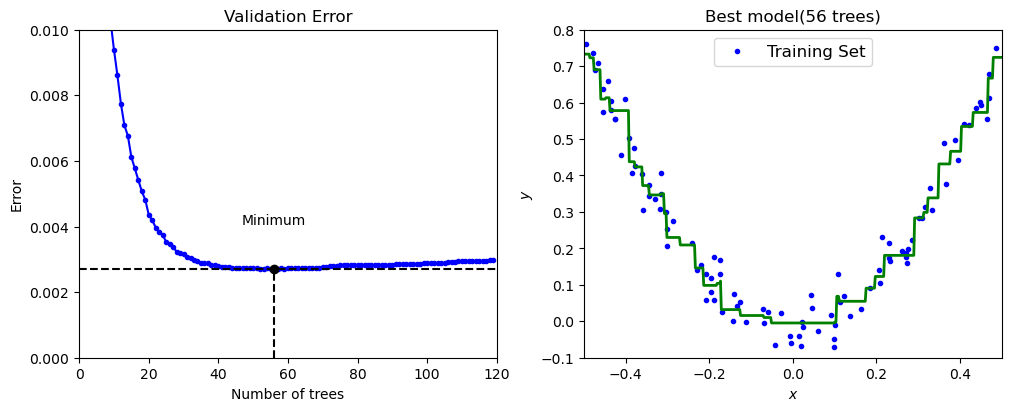

In [58]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100, constrained_layout=True)

axes[0].plot(errors, "b.-")
axes[0].plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
axes[0].plot([0, 120], [min_error, min_error], "k--")

axes[0].plot(bst_n_estimators, min_error, "ko")
axes[0].text(
    bst_n_estimators, min_error * 1.5, "Minimum", ha="center", fontsize="medium"
)
axes[0].set(
    xlim=[0, 120],
    ylim=[0, 0.01],
    xlabel="Number of trees",
    ylabel="Error",
    title="Validation Error",
)

plot_predictions([gbrt_best], X, y, lims=[-0.5, 0.5, -0.1, 0.8], ax=axes[1])
axes[1].set(xlabel="$x$", ylabel="$y$", title=f"Best model({bst_n_estimators} trees)")

plt.show()

In [59]:
gbrt = GradientBoostingRegressor(max_depth=2,warm_start=True,random_state=42)
# WARM_START

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred= gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # Early Stopping


In [60]:
print(gbrt.n_estimators)

61


In [61]:
print("Minimum Validation MSE:", min_val_error)

Minimum Validation MSE: 0.002712853325235463


## Voting Classifier

In [62]:
X = pd.read_feather('../data/mnist_784_X.feather')
y = pd.read_feather('../data/mnist_784_y.feather')
X = X.to_numpy()
y = y.to_numpy()

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42
)

In [65]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [66]:
random_forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100,random_state=42)
svm_clf = LinearSVC(max_iter=100,tol=20,random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [67]:
estimators = [random_forest_clf,extra_trees_clf,svm_clf,mlp_clf]

for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train,y_train)
#time

Training the RandomForestClassifier(random_state=42)


/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_11572/4013534995.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,y_train)


Training the ExtraTreesClassifier(random_state=42)


/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_11572/4013534995.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train,y_train)


Training the LinearSVC(max_iter=100, random_state=42, tol=20)


/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training the MLPClassifier(random_state=42)


/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
[estimator.score(X_val,y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9629]

In [69]:
### import the Voting classifier 
from sklearn.ensemble import VotingClassifier

In [70]:
named_estimators = [("random_forest_clf",random_forest_clf),
                    ("extra_trees_clf",extra_trees_clf),
                    ("svm_clf",svm_clf),
                    ("mlp_clf",mlp_clf)]

In [71]:
voting_clf = VotingClassifier(named_estimators)

In [72]:
voting_clf.fit(X_train,y_train)

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [73]:
voting_clf.score(X_val,y_val)

0.9703

In [74]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9629]

In [75]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [76]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [77]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [78]:
del voting_clf.estimators_[2]

In [79]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 MLPClassifier(random_state=42)]

In [80]:
voting_clf.voting = "soft"

In [81]:
voting_clf.score(X_val,y_val)

0.9704

In [82]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9706

In [83]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.9629]

### Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [84]:
estimators

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [85]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:,index] = estimator.predict(X_val)
                                  

In [86]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [87]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200,oob_score=True,random_state=42)
rnd_forest_blender.fit(X_val_predictions,y_val)



/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_11572/3861240722.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_forest_blender.fit(X_val_predictions,y_val)


RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [88]:
rnd_forest_blender.oob_score_

0.9695

Evaluate the ensemble on the test set.

In [89]:
X_test_predictions = np.empty((len(X_test),len(estimators)),dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:,index] = estimator.predict(X_test)

In [90]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [91]:
from sklearn.metrics import accuracy_score

In [92]:
accuracy_score(y_test, y_pred)

0.9678

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.

### XGBoost

In [93]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

In [94]:
import xgboost

In [95]:
xgb_reg = xgboost.XGBClassifier(random_state=42)
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val,y_pred)
print("Validation MSE:",val_error)

/usr/local/Caskroom/miniconda/base/envs/p39/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:34:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation MSE: 0.16071325195945765


In [96]:
%timeit xgboost.XGBRegressor().fit(X_train,y_train)

40 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

18.5 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
